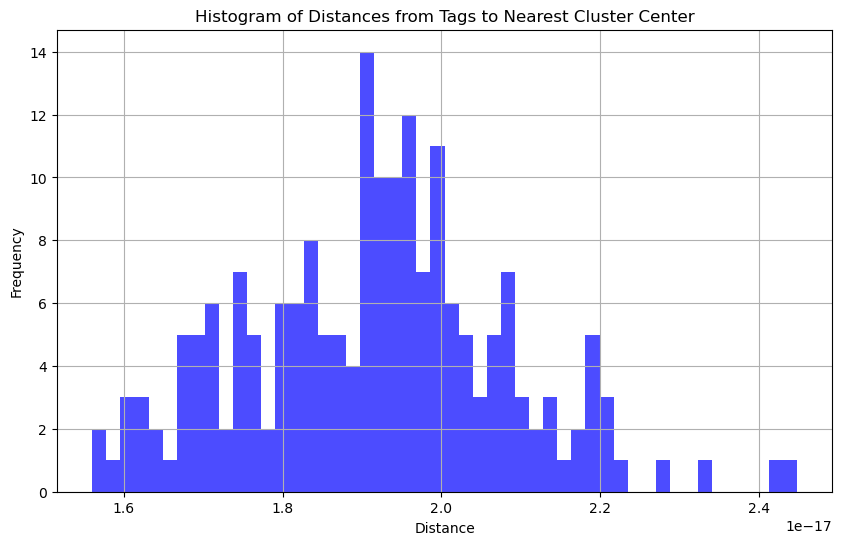

{'mean': 1.9153109287924826e-17,
 'median': 1.922561033161508e-17,
 'std_dev': 1.6551485810160854e-18,
 '95th_percentile': 2.1931352659688857e-17}

In [20]:
# Re-import the necessary libraries
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist


with open('data/emo_map_list.txt', 'r') as f:
    theme_tags = eval(f.read()) # load theme tags
with open('emomap_embeddings_ada002.json', 'r') as f:
    theme_dictionary = json.load(f)
unique_theme_tags = list(theme_dictionary.keys()) # load unique tags
theme_embeddings = list(theme_dictionary.values()) # load filtered tags

df_tag = pd.DataFrame()
df_tag['tag'] = pd.Series(list(set(theme_tags)))
tag_counts = {tag: theme_tags.count(tag) for tag in df_tag['tag'].unique()}
df_tag['count'] = df_tag['tag'].map(tag_counts)
df_tag['filter_tag'] = df_tag['tag']
data = df_tag


# Extract the initial cluster centers
initial_cluster_centers_tags = data['filter_tag'].dropna().unique()
initial_cluster_centers_embeddings = np.array([theme_dictionary[tag] for tag in initial_cluster_centers_tags])

# Initialize KMeans with the number of initial clusters
num_initial_clusters = len(initial_cluster_centers_embeddings)
kmeans = KMeans(n_clusters=num_initial_clusters, init=initial_cluster_centers_embeddings, n_init=1, max_iter=300)

# Extract the embeddings for all tags
all_tags = data['tag'].unique()
all_embeddings = np.array([theme_dictionary[tag] for tag in all_tags if tag in theme_dictionary])

# Fit KMeans algorithm on all embeddings
kmeans.fit(all_embeddings)
labels = kmeans.labels_

# Calculate the distance of each tag to its assigned cluster center
distances = cdist(all_embeddings, kmeans.cluster_centers_[labels], metric='euclidean').diagonal()
tag_cluster_mapping = pd.DataFrame({'tag': all_tags, 'cluster': labels, 'distance_to_center': distances})

# Plot a histogram of the distances
plt.figure(figsize=(10, 6))
plt.hist(distances, bins=50, alpha=0.7, color='blue')
plt.title('Histogram of Distances from Tags to Nearest Cluster Center')
plt.xlabel('Distance')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Calculate descriptive statistics for the distances
distance_statistics = {
    'mean': np.mean(distances),
    'median': np.median(distances),
    'std_dev': np.std(distances),
    '95th_percentile': np.percentile(distances, 95)
}

distance_statistics


In [32]:
import numpy as np
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
import random

# Assuming `theme_dictionary` is your dictionary of tag embeddings
# And `tags` is your list of tag names
tags = all_tags
# Step 1: Create pairs of tags for training
def create_pairs(tags, num_positive_pairs, num_negative_pairs):
    positive_pairs = []
    negative_pairs = []
    
    # Generate positive pairs (similar tags)
    for _ in range(num_positive_pairs):
        tag1 = random.choice(tags)
        tag2 = random.choice(tags)  # Replace with a mechanism to choose a similar tag
        positive_pairs.append([theme_dictionary[tag1], theme_dictionary[tag2]])
        
    # Generate negative pairs (dissimilar tags)
    for _ in range(num_negative_pairs):
        tag1 = random.choice(tags)
        tag2 = random.choice(tags)  # Replace with a mechanism to choose a dissimilar tag
        negative_pairs.append([theme_dictionary[tag1], theme_dictionary[tag2]])
        
    return np.array(positive_pairs), np.array(negative_pairs)

# Step 2: Prepare embeddings
# For this example, let's assume we want 1000 positive and 1000 negative pairs
positive_pairs, negative_pairs = create_pairs(list(theme_dictionary.keys()), 1000, 1000)

# Step 3: Build a Siamese Network
input_shape = positive_pairs.shape[2:]
input_a = Input(shape=input_shape)
input_b = Input(shape=input_shape)

shared_dense = Dense(128, activation='relu')

processed_a = shared_dense(input_a)
processed_b = shared_dense(input_b)

# L1 distance between transformed inputs
l1_distance_layer = Lambda(lambda tensors: K.abs(tensors[0] - tensors[1]))
l1_distance = l1_distance_layer([processed_a, processed_b])

# Output layer with a single neuron and sigmoid activation function
prediction = Dense(1, activation='sigmoid')(l1_distance)

siamese_net = Model(inputs=[input_a, input_b], outputs=prediction)

# Step 4: Define Loss Function
siamese_net.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Step 5: Train the Model
# Create labels for the pairs: 1 for positive, 0 for negative
labels = np.concatenate([np.ones(len(positive_pairs)), np.zeros(len(negative_pairs))])
pairs = np.concatenate([positive_pairs, negative_pairs], axis=0)

# Reshape for training
pairs = [pairs[:, 0], pairs[:, 1]]  # Split pairs into two separate arrays

siamese_net.fit(pairs, labels, epochs=20, batch_size=128)


Epoch 1/20
16/16 [==============================] - 0s 3ms/step - loss: 0.6938 - accuracy: 0.4995
Epoch 2/20
16/16 [==============================] - 0s 3ms/step - loss: 0.6885 - accuracy: 0.5795
Epoch 3/20
16/16 [==============================] - 0s 2ms/step - loss: 0.6839 - accuracy: 0.6680
Epoch 4/20
16/16 [==============================] - 0s 3ms/step - loss: 0.6785 - accuracy: 0.7000
Epoch 5/20
16/16 [==============================] - 0s 3ms/step - loss: 0.6720 - accuracy: 0.7050
Epoch 6/20
16/16 [==============================] - 0s 3ms/step - loss: 0.6642 - accuracy: 0.7225
Epoch 7/20
16/16 [==============================] - 0s 3ms/step - loss: 0.6553 - accuracy: 0.7380
Epoch 8/20
16/16 [==============================] - 0s 3ms/step - loss: 0.6449 - accuracy: 0.7475
Epoch 9/20
16/16 [==============================] - 0s 3ms/step - loss: 0.6337 - accuracy: 0.7515
Epoch 10/20
16/16 [==============================] - 0s 3ms/step - loss: 0.6218 - accuracy: 0.7520
Epoch 11/20
16/16 [

In [39]:
# Assuming `siamese_net` is your trained Siamese network and `shared_dense` is the shared layer

# Step 6: Extract New Embeddings
# Extract the dense layer from the Siamese network as a separate model
# Assuming `siamese_net` is your trained Siamese network and `shared_dense` is the shared dense layer

# Step 6: Extract New Embeddings
# Get the output of the shared dense layer
dense_output = shared_dense.output
# Create a new model that takes the same input as the Siamese network and outputs the dense layer output
dense_layer_model = Model(inputs=shared_dense.input, outputs=dense_output)

# Pass all original embeddings through the dense layer to get refined embeddings
refined_embeddings = dense_layer_model.predict(np.array(list(theme_dictionary.values())))

# Step 7: Clustering with Refined Embeddings
from sklearn.cluster import KMeans

# Number of clusters can be set based on prior knowledge or determined using methods like the elbow method
num_clusters = 25 # Example number, needs to be chosen based on your data
kmeans = KMeans(n_clusters=num_clusters, random_state=0)
cluster_labels = kmeans.fit_predict(refined_embeddings)

# Output clustering result
# Create a mapping of tags to their clusters

tag_to_cluster = {tag: cluster for tag, cluster in zip(theme_dictionary.keys(), cluster_labels)}

6/6 [==============================] - 0s 910us/step


/opt/homebrew/Caskroom/miniforge/base/envs/cq1/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [40]:
# Assuming `tag_to_cluster` is a dictionary mapping tags to their clusters
tag_to_cluster = {tag: cluster for tag, cluster in zip(theme_dictionary.keys(), cluster_labels)}

# Convert the tag_to_cluster dictionary to a DataFrame
tag_cluster_df = pd.DataFrame(list(tag_to_cluster.items()), columns=['tag', 'Cluster'])
tag_cluster_df.sort_values('Cluster')
tag_cluster_df.sort_values('Cluster').to_excel('emotion25_20.xlsx')


In [15]:
import math
import ast
from collections import Counter

movie_tags = pd.read_csv('data/emotion_keep.csv')
theme_tags = [] # movie_tags中theme集合
# emo_tags = [] # movie_tags中emotion集合

themes = [i for i in movie_tags['tags_emotion'].tolist() if not (isinstance(i, float) and math.isnan(i))]
# emos = [i for i in movie_tags['tags_emotion'].tolist() if not (isinstance(i, float) and math.isnan(i))]

for th in themes:
    formatted_th = th.replace("' '", "', '")
    try:
        theme_list = ast.literal_eval(formatted_th)
        theme_tags.extend(theme_list)
    except ValueError as e:
        print(f"Error converting {formatted_th}: {e}")

# for th in emos:
#     formatted_th = th.replace("' '", "', '")
#     try:
#         emos_list = ast.literal_eval(formatted_th)
#         emo_tags.extend(emos_list)
#     except ValueError as e:
#         print(f"Error converting {formatted_th}: {e}")

# seen_th = set()
# # theme_tags.extend(emo_tags) # all tags records
# counts_th = Counter(theme_tags)
# unique_theme_tags = list(set(theme_tags)) # unique tags
# filtered_theme_tags = [x for x in theme_tags if counts_th[x] >= 5 and (x not in seen_th and not seen_th.add(x))]
movie_tags['tags_emotion'].tolist()
with open('data/emo_map_list.txt', 'w') as f:
    f.write(str(theme_tags)) 
# with open('data/emo_only_list.txt', 'w') as f:
#     f.write(str(emo_tags)) 

Error converting 伤心: malformed node or string: <ast.Name object at 0x1796bcdc0>
Error converting 发现: malformed node or string: <ast.Name object at 0x1796bcf40>
Error converting 奉献: malformed node or string: <ast.Name object at 0x1796bc250>
Error converting 颠覆: malformed node or string: <ast.Name object at 0x1796bc550>
Error converting 温馨: malformed node or string: <ast.Name object at 0x1796bc280>
Error converting 夺船: malformed node or string: <ast.Name object at 0x1796bceb0>
Error converting 牺牲: malformed node or string: <ast.Name object at 0x1796bc9a0>
Error converting 难过: malformed node or string: <ast.Name object at 0x1796bcbe0>
Error converting 震惊: malformed node or string: <ast.Name object at 0x1796bc4c0>
Error converting 压抑: malformed node or string: <ast.Name object at 0x1796bc2e0>
Error converting 自然: malformed node or string: <ast.Name object at 0x1796bc670>
Error converting 敌对: malformed node or string: <ast.Name object at 0x17a903490>
Error converting 嚣张: malformed node or s

In [16]:
movie_tags = pd.read_csv('data/emotion_keep.csv')
theme_tags = movie_tags['tags_emotion'].tolist()
with open('data/emo_map_list.txt', 'w') as f:
    f.write(str(theme_tags)) 